In [1]:
import jax.numpy as jnp
from PIL.ImageChops import offset
from jax import grad, jit, vmap
from jax import random

import matplotlib.pyplot as plt

import numpy as np
from qtconsole.mainwindow import background
from scipy.stats import alpha

from Utils.models import *
from Utils.simulation import *
from Utils.plot_utils import *

import time
from copy import copy

%load_ext autoreload
%autoreload 2

In [2]:
2**7

128

In [3]:
params_dict = {
    "dataset_parameters": {
        "n_samples": 200 
    },
    "network_parameters": {
        "input_size": 64,
        "hidden_size": 128,
        "output_size": 1,
        "bias": 1,
    },
    "training_parameters": {
        "num_epochs": 100,
        "learning_rate": 0.01
    },
    "simulation_parameters": {
        "mu": 1,
        "sigma": 0.1,
        "theta": 0.02,
        "dt": 0.001,
        "tau": 0.005
    },
    "seed": 42
}

In [4]:
rng = random.key(params_dict["seed"])

In [5]:
mu_LN = mu_LN_from_params(**params_dict["simulation_parameters"])
sigma_LN = sigma_LN_from_params(**params_dict["simulation_parameters"])

rng, net_key = random.split(rng)
params = init_elm(net_key, mu_LN, sigma_LN, **params_dict["network_parameters"])

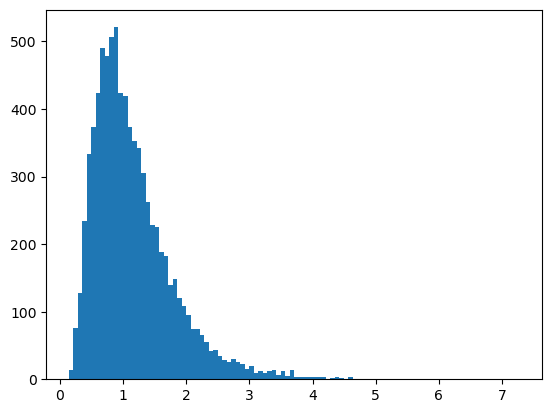

In [6]:
#histogram of the weights of W_i
plt.hist(params['W_i'].flatten(), bins=100)
plt.show()


In [7]:
# simulate perturbations of the weights of W_i
simulation_parameters = params_dict["simulation_parameters"]
rng, sim_key = random.split(rng)
weight_list = simulate_perturbation_only(sim_key, params['W_i'].flatten(), 1000, simulation_parameters['mu'], simulation_parameters['theta'], simulation_parameters['sigma'], simulation_parameters['dt'])


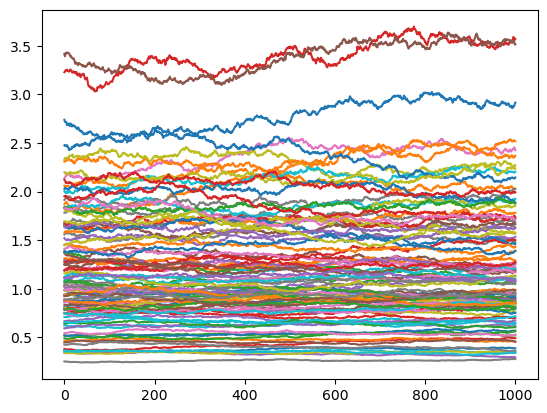

In [8]:
plt.plot(weight_list[:, :100])

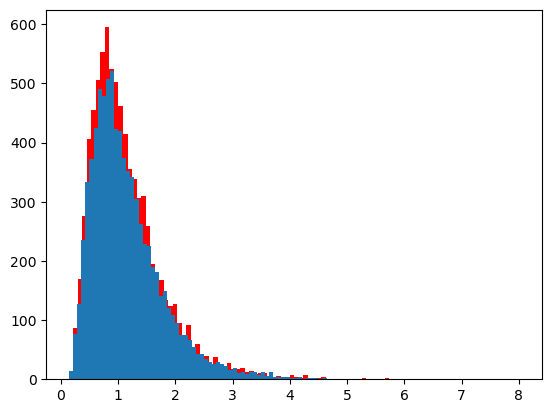

In [9]:
#histogram of final weights
plt.hist(weight_list[-1], bins=100, color='r')
plt.hist(params['W_i'].flatten(), bins=100)
plt.show()



In [10]:
#simulate perturbations of the weights of W_i
rng, sim_key = random.split(rng)
W_f = time_evolution_GOU(sim_key, params['W_i'], **simulation_parameters)



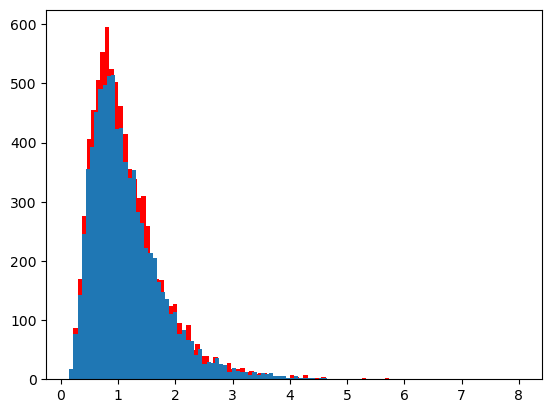

In [11]:
plt.hist(weight_list[-1], bins=100, color='r')
plt.hist(W_f.flatten(), bins=100)
plt.show()

In [12]:
rng, data_key = random.split(rng)

X_train, y_train = create_binary_dataset(data_key, 
                                         n_samples=params_dict["dataset_parameters"]["n_samples"],
                                         input_dim=params_dict["network_parameters"]["input_size"])

In [13]:

loss_list = []
acc_list = []

training_parameters = params_dict["training_parameters"]
num_epochs = training_parameters["num_epochs"]
learning_rate = training_parameters["learning_rate"]
simulation_parameters = params_dict["simulation_parameters"]

weight_list = []
rng = random.key(params_dict["seed"])
for epoch in range(num_epochs):
    start_time = time.time()
    for x,y in zip(X_train,y_train):

        rng, gou_key = random.split(rng)
        #perturb the weights of W_i
        params['W_i'] = time_evolution_GOU(gou_key, params['W_i'], **simulation_parameters)
        #params['W_i'] += perturb_GOU(gou_key, params['W_i'], simulation_parameters['mu'], simulation_parameters['theta'], simulation_parameters['sigma'], simulation_parameters['dt'])
        
        grads = grad(loss_elm)(params, x, y)
        params['W_i'] -= learning_rate * grads['W_i']
        params['W_o'] -= learning_rate * grads['W_o']
        params['b_i'] -= learning_rate * grads['b_i']
        params['b_o'] -= learning_rate * grads['b_o']
            
        weight_list.append(params['W_i'].flatten())
        
    acc_list.append(accuracy_elm(params, X_train, y_train))
    loss_list.append(loss_elm(params, X_train, y_train))


    if epoch%10==0:
        epoch_time = time.time() - start_time
        train_loss = loss_elm(params, X_train, y_train)
        train_acc = accuracy_elm(params, X_train, y_train)
        print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
        print("Training set loss {}".format(train_loss))
        print("Training set accuracy {}".format(train_acc))




Epoch 0 in 4.19 sec
Training set loss 1.3146978616714478
Training set accuracy 0.45499998331069946
Epoch 10 in 2.66 sec
Training set loss 0.7808533906936646
Training set accuracy 0.5849999785423279
Epoch 20 in 3.68 sec
Training set loss 0.6466817259788513
Training set accuracy 0.6549999713897705
Epoch 30 in 3.43 sec
Training set loss 0.5602946877479553
Training set accuracy 0.7149999737739563
Epoch 40 in 2.40 sec
Training set loss 0.4418236315250397
Training set accuracy 0.7899999618530273
Epoch 50 in 2.53 sec
Training set loss 0.36385053396224976
Training set accuracy 0.8399999737739563
Epoch 60 in 2.31 sec
Training set loss 0.40047386288642883
Training set accuracy 0.8199999928474426
Epoch 70 in 2.31 sec
Training set loss 0.36971431970596313
Training set accuracy 0.8449999690055847
Epoch 80 in 2.33 sec
Training set loss 0.465091735124588
Training set accuracy 0.7799999713897705
Epoch 90 in 2.35 sec
Training set loss 0.36168110370635986
Training set accuracy 0.8399999737739563


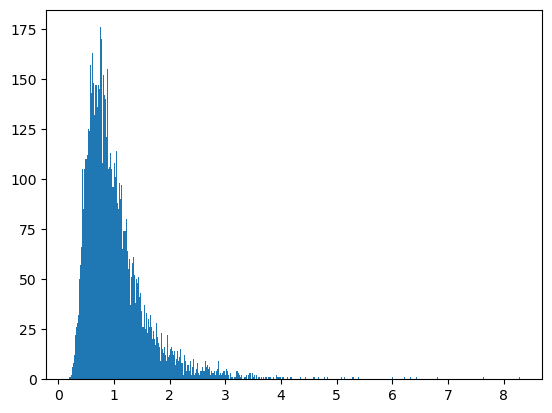

In [14]:
weight_list = np.array(weight_list)
plt.hist(weight_list[-1], bins=500)
plt.show()


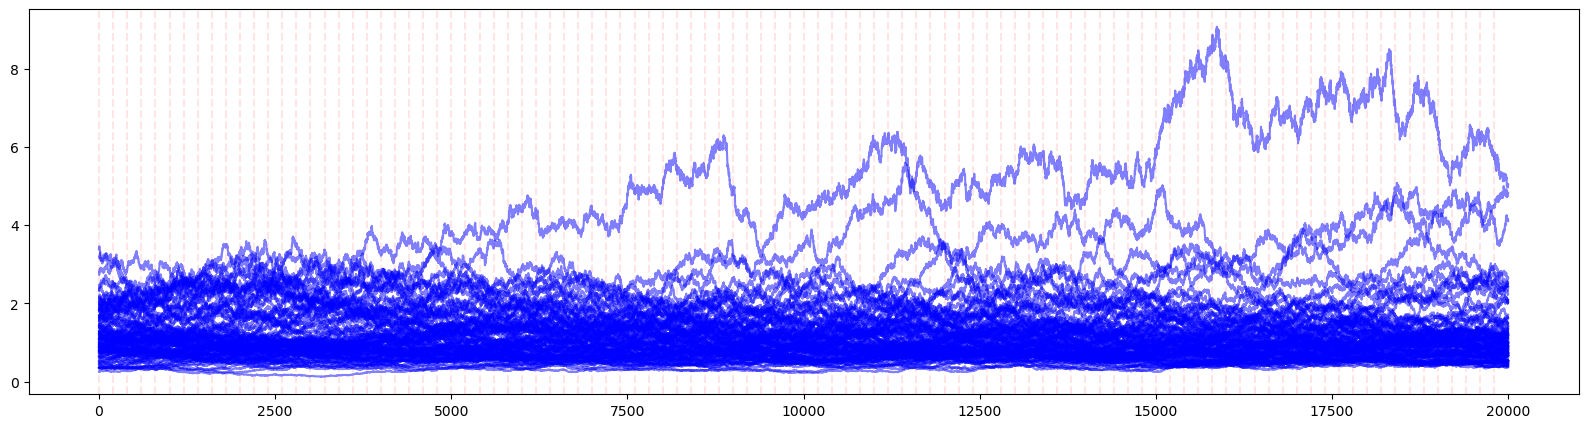

In [15]:
#make a long figure
plt.figure(figsize=(20,5))

#plot 

# put a  vertical line every 200 steps
for i in range(0, num_epochs*200, 200):
    plt.axvline(x=i, color='r', linestyle='--', alpha = 0.1)
plt.plot(weight_list[:, :100], alpha=0.5, c = 'b')

plt.show()
    



In [16]:
#save the data
np.save("old_results/weight_list_training.npy", weight_list)

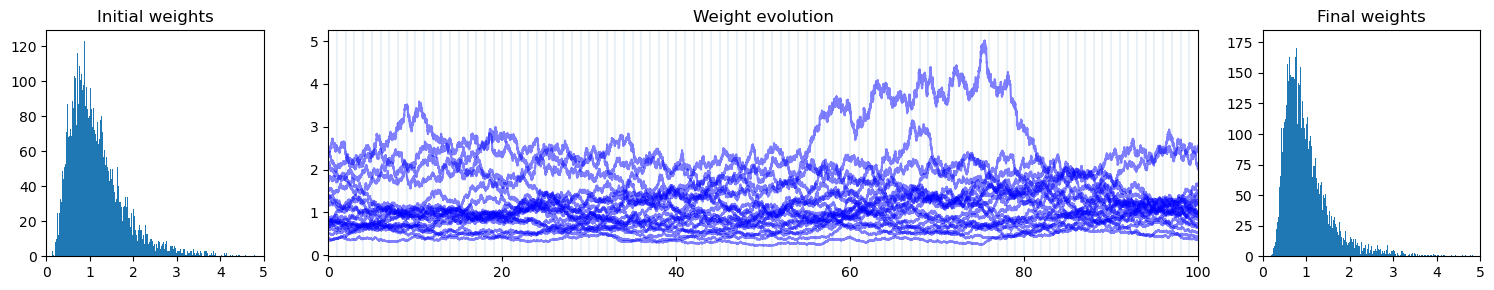

In [34]:
weight_list = np.load("old_results/weight_list_training.npy")

fig, axs = plt.subplots(1, 3, figsize=(15, 3), gridspec_kw={'width_ratios': [1, 4, 1]})

# Plot the initial weights
axs[0].hist(weight_list[0], bins=500)
axs[0].set_title("Initial weights")
axs[0].set_xlim(0, 5)
# Plot the weight evolution

for i in np.arange(0, num_epochs, 1):
    axs[1].axvline(x=i*(simulation_parameters['tau'])*200, alpha = 0.1)
times = np.arange(0, num_epochs*200) * simulation_parameters['tau']
axs[1].plot(times, weight_list[:, :20], alpha=0.5, c = 'b')
axs[1].set_title("Weight evolution")
axs[1].set_xlim(0, num_epochs*200*simulation_parameters['tau'])

# Plot the final weights
axs[2].hist(weight_list[-1], bins=500)
axs[2].set_title("Final weights")
axs[2].set_xlim(0, 5)

plt.savefig("weight_evolution.png", dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

In [20]:
times.shape

(20000,)

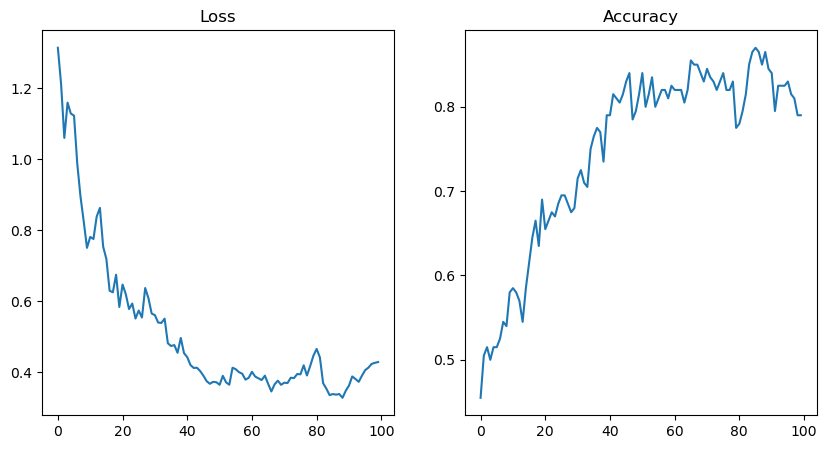

In [21]:
#plot losses and accuracy next to each other
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(loss_list)
ax[0].set_title("Loss")
ax[1].plot(acc_list)
ax[1].set_title("Accuracy")
plt.show()


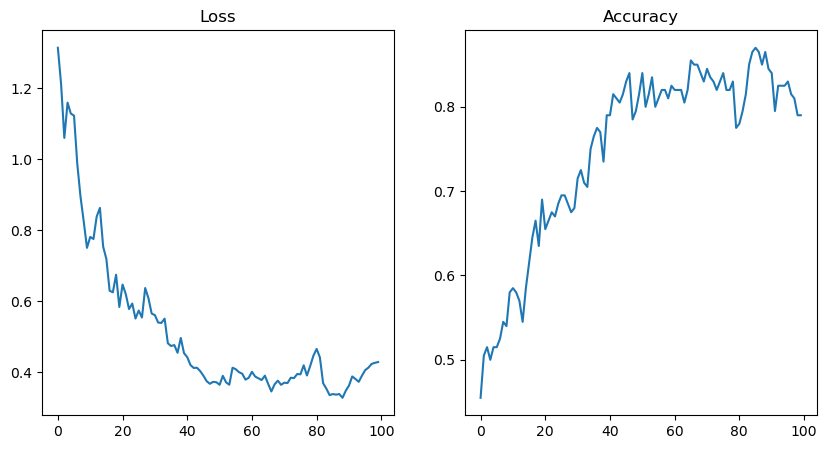

In [22]:
    #plot losses and accuracy next to each other
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(loss_list)
ax[0].set_title("Loss")
ax[1].plot(acc_list)
ax[1].set_title("Accuracy")
plt.show()



In [23]:
for epoch in range(num_epochs):
    start_time = time.time()
    for x,y in zip(X_train,y_train):
        #perturb the weights of W_i
        rng, gou_key = random.split(rng)
        params['W_i'] = time_evolution_GOU(gou_key, params['W_i'], **simulation_parameters)

    acc_list.append(accuracy_elm(params, X_train, y_train))
    loss_list.append(loss_elm(params, X_train, y_train))


    if epoch%10==0:
        epoch_time = time.time() - start_time
        train_loss = loss_elm(params, X_train, y_train)
        train_acc = accuracy_elm(params, X_train, y_train)
        print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
        print("Training set loss {}".format(train_loss))
        print("Training set accuracy {}".format(train_acc))

Epoch 0 in 0.73 sec
Training set loss 0.4534252882003784
Training set accuracy 0.7899999618530273
Epoch 10 in 0.41 sec
Training set loss 0.9226993322372437
Training set accuracy 0.5849999785423279
Epoch 20 in 0.43 sec
Training set loss 1.2660552263259888
Training set accuracy 0.5349999666213989
Epoch 30 in 0.44 sec
Training set loss 1.067439079284668
Training set accuracy 0.574999988079071
Epoch 40 in 0.43 sec
Training set loss 1.2469546794891357
Training set accuracy 0.5099999904632568
Epoch 50 in 0.43 sec
Training set loss 1.250045657157898
Training set accuracy 0.4949999749660492
Epoch 60 in 0.43 sec
Training set loss 2.2697091102600098
Training set accuracy 0.44999998807907104
Epoch 70 in 0.44 sec
Training set loss 2.2492964267730713
Training set accuracy 0.4599999785423279
Epoch 80 in 0.43 sec
Training set loss 2.8081963062286377
Training set accuracy 0.45499998331069946
Epoch 90 in 0.44 sec
Training set loss 1.528969645500183
Training set accuracy 0.5049999952316284


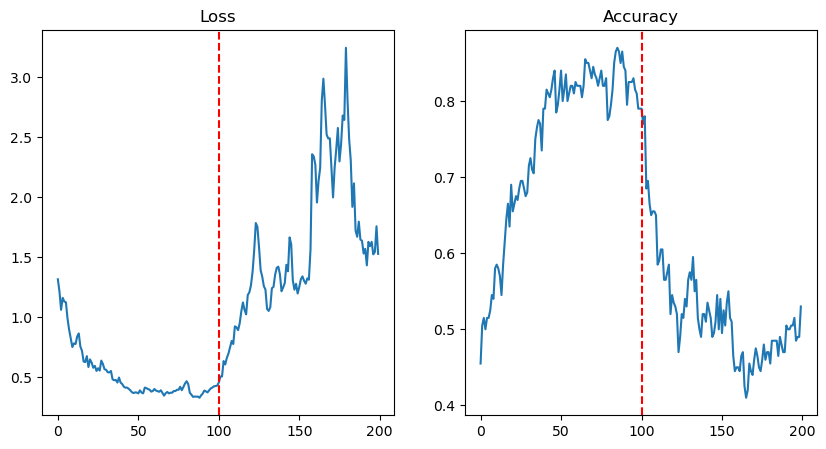

In [24]:
#plot losses and accuracy next to each other
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(loss_list)
ax[0].set_title("Loss")
ax[1].plot(acc_list)
ax[1].set_title("Accuracy")
#vertical line to show the end of the training
ax[0].axvline(x=num_epochs, color='r', linestyle='--')
ax[1].axvline(x=num_epochs, color='r', linestyle='--')
plt.show()


[]

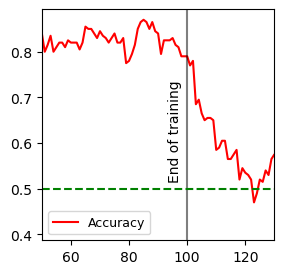

In [31]:
plt.figure(figsize=(3,3))
epochs_time = np.arange(0, num_epochs*2)*simulation_parameters['tau']*200
plt.plot(epochs_time,acc_list, 'r', label='Accuracy')
#vertical line to show the end of the training
plt.axvline(x=num_epochs*200*simulation_parameters['tau'], color='k', alpha = 0.5)
# write that the vertical line is the end of training
plt.text(num_epochs*187*simulation_parameters['tau'],  0.52,'End of training',rotation=90)
#horizonatal line at 0.5
plt.axhline(y=0.5, color='g', linestyle='--')
#transparent legend
plt.legend(fontsize=9)
plt.xlim(50,130)
plt.savefig("accuracy.png", dpi=300, bbox_inches='tight')

plt.plot()

# DIFFERENT TAUS

In [36]:
rng = random.key(params_dict["seed"])

mu_LN = mu_LN_from_params(**params_dict["simulation_parameters"])
sigma_LN = sigma_LN_from_params(**params_dict["simulation_parameters"])

rng, data_key = random.split(rng)

X_train, y_train = create_binary_dataset(data_key, n_samples=params_dict["dataset_parameters"]["n_samples"], input_dim=params_dict["network_parameters"]["input_size"])

tau_list = jnp.arange(0.00, 0.05, 0.005)
loss_tau = []
acc_tau = []

training_parameters = params_dict["training_parameters"]
num_epochs = training_parameters["num_epochs"]
learning_rate = training_parameters["learning_rate"]
simulation_parameters = params_dict["simulation_parameters"]

print('tau_list', tau_list)

for tau in tau_list:
    print("Tau: ", tau)
    simulation_parameters["tau"] = tau
    rng, net_key = random.split(rng)
    params = init_elm(net_key, mu_LN, sigma_LN, **params_dict["network_parameters"])

    for epoch in range(num_epochs):
        for x,y in zip(X_train,y_train):

            rng, gou_key = random.split(rng)
            #perturb the weights of W_i
            
            if tau != 0:
                params['W_i'] = time_evolution_GOU(gou_key, params['W_i'], **simulation_parameters)
            #params['W_i'] += perturb_GOU(gou_key, params['W_i'], simulation_parameters['mu'], simulation_parameters['theta'], simulation_parameters['sigma'], simulation_parameters['dt'])
            
            grads = grad(loss_elm)(params, x, y)
            params['W_i'] -= learning_rate * grads['W_i']
            params['W_o'] -= learning_rate * grads['W_o']
            params['b_i'] -= learning_rate * grads['b_i']
            params['b_o'] -= learning_rate * grads['b_o']
            
        if epoch%10==0:
            print("Epoch {}. Acc = {}".format(epoch,accuracy_elm(params, X_train, y_train)))          

    print("Loss: ",loss_elm(params, X_train, y_train))
    print("Accuracy: ", accuracy_elm(params, X_train, y_train))
    acc_tau.append(accuracy_elm(params, X_train, y_train))
    loss_tau.append(loss_elm(params, X_train, y_train))
    

tau_list [0.    0.005 0.01  0.015 0.02  0.025 0.03  0.035 0.04  0.045]
Tau:  0.0
Epoch 0. Acc = 0.5550000071525574
Epoch 10. Acc = 0.7899999618530273
Epoch 20. Acc = 0.85999995470047
Epoch 30. Acc = 0.8999999761581421
Epoch 40. Acc = 0.9300000071525574
Epoch 50. Acc = 0.9599999785423279
Epoch 60. Acc = 0.98499995470047
Epoch 70. Acc = 0.9950000047683716
Epoch 80. Acc = 1.0
Epoch 90. Acc = 1.0
Loss:  0.072031066
Accuracy:  1.0
Tau:  0.005
Epoch 0. Acc = 0.5149999856948853
Epoch 10. Acc = 0.7599999904632568


KeyboardInterrupt: 

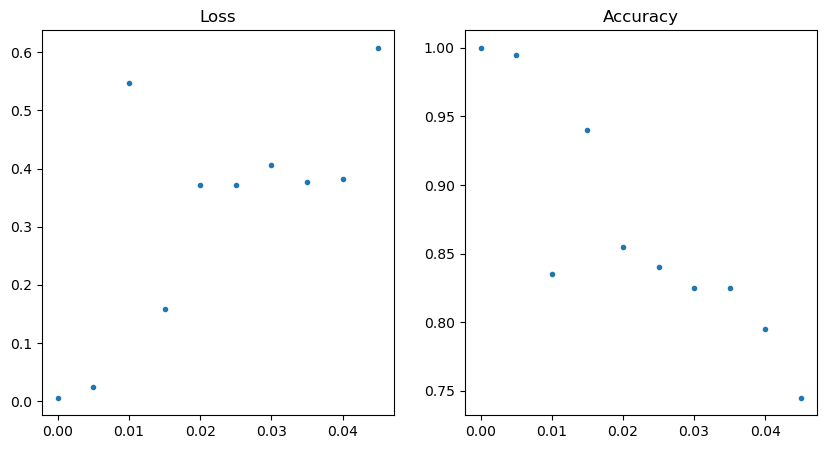

In [80]:
#plot losses and accuracy next to each other
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(tau_list, loss_tau, '.')
ax[0].set_title("Loss")
ax[1].plot(tau_list,acc_tau, '.')
ax[1].set_title("Accuracy")
plt.show()


In [131]:
#save loss and accuracy
np.save("old_results/loss_tau.npy", loss_tau)
np.save("old_results/acc_tau.npy", acc_tau)


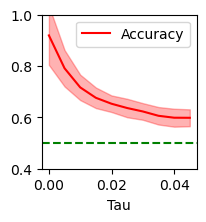

In [50]:
tau_list = jnp.arange(0.00, 0.05, 0.005)
acc_tau = np.load("old_results/acc_tau_tot.npy")

plt.figure(figsize=(2,2))
plt.plot(tau_list, np.mean(acc_tau, axis=1), 'r', label='Accuracy')
plt.fill_between(tau_list, np.mean(acc_tau, axis=1) - np.std(acc_tau, axis=1),
                   np.mean(acc_tau, axis=1) + np.std(acc_tau, axis=1), alpha=0.3, color = 'r')

plt.xlabel('Tau')
plt.ylim(0.4,1)
#horizonatal line at 0.5
plt.axhline(y=0.5, color='g', linestyle='--')
plt.legend()
plt.savefig("tau_accuracy.png", dpi=300, bbox_inches='tight')
plt.show()

In [20]:
ax[0].plot(tau_list, np.mean(acc_tau, axis=1), label='Accuracy')
ax[0].fill_between(tau_list, np.mean(acc_tau, axis=1) - np.std(acc_tau, axis=1),
                   np.mean(acc_tau, axis=1) + np.std(acc_tau, axis=1), alpha=0.3)
ax[0].set_xlabel('Tau')
ax[0].set_ylabel('Accuracy')

(10, 1000)

# TAU EXPLORATION with MLP

In [32]:
tau_list = jnp.arange(0.00, 0.1, 0.005)
loss_tau = []
acc_tau = []

training_parameters = params_dict["training_parameters"]
num_epochs = training_parameters["num_epochs"]
learning_rate = training_parameters["learning_rate"]
simulation_parameters = params_dict["simulation_parameters"]

print('tau_list', tau_list)



tau_list [0.    0.005 0.01  0.015 0.02  0.025 0.03  0.035 0.04  0.045 0.05  0.055
 0.06  0.065 0.07  0.075 0.08  0.085 0.09  0.095]


In [54]:
rng = random.key(params_dict["seed"])

mu_LN = mu_LN_from_params(**params_dict["simulation_parameters"])
sigma_LN = sigma_LN_from_params(**params_dict["simulation_parameters"])

tau_list = jnp.arange(0.00, 0.1, 0.005)
loss_tau = []
acc_tau = []

training_parameters = params_dict["training_parameters"]
num_epochs = training_parameters["num_epochs"]
learning_rate = training_parameters["learning_rate"]
simulation_parameters = params_dict["simulation_parameters"]

print('tau_list', tau_list)

for tau in tau_list:
    print("Tau: ", tau)
    simulation_parameters["tau"] = tau
    rng, net_key = random.split(rng)
    params = init_mlp(net_key, mu_LN, sigma_LN, **params_dict["network_parameters"])

    for epoch in range(num_epochs):
        start_time = time.time()
        for x,y in zip(X_train,y_train):

            rng, gou_key = random.split(rng)
            #perturb the weights of W_i
            
            if tau != 0:
                params['W_h'] = time_evolution_GOU(gou_key, params['W_h'], **simulation_parameters)
            #params['W_i'] += perturb_GOU(gou_key, params['W_i'], simulation_parameters['mu'], simulation_parameters['theta'], simulation_parameters['sigma'], simulation_parameters['dt'])
            
            grads = grad(loss_mlp)(params, x, y)
            params['W_i'] -= learning_rate * grads['W_i']
            params['W_h'] -= learning_rate * grads['W_h']
            params['W_o'] -= learning_rate * grads['W_o']
                
        if epoch%10==0:
            epoch_time = time.time() - start_time
            print("Epoch {} in {:0.2f} sec. Acc = {}".format(epoch, epoch_time,accuracy_mlp(params, X_train, y_train)))              

    print("Loss: ",loss_mlp(params, X_train, y_train))
    print("Accuracy: ", accuracy_mlp(params, X_train, y_train))
    acc_tau.append(accuracy_mlp(params, X_train, y_train))
    loss_tau.append(loss_mlp(params, X_train, y_train))



tau_list [0.    0.005 0.01  0.015 0.02  0.025 0.03  0.035 0.04  0.045 0.05  0.055
 0.06  0.065 0.07  0.075 0.08  0.085 0.09  0.095]
Tau:  0.0
Epoch 0 in 2.08 sec. Acc = 0.5299999713897705
Epoch 10 in 1.82 sec. Acc = 0.8949999809265137


KeyboardInterrupt: 

dict_keys(['W_i', 'W_h', 'W_o', 'bias'])

In [32]:
loss_list = []
acc_list = []

params = init_elm(net_key, mu_LN, sigma_LN, **params_dict["network_parameters"])

rng, data_key = random.split(rng)

X_train, y_train = create_binary_dataset(data_key, 
                                         n_samples=params_dict["dataset_parameters"]["n_samples"],
                                         input_dim=params_dict["network_parameters"]["input_size"])

training_parameters = params_dict["training_parameters"]
num_epochs = training_parameters["num_epochs"]
learning_rate = training_parameters["learning_rate"]
simulation_parameters = params_dict["simulation_parameters"]

weight_list = []
rng = random.key(params_dict["seed"])
for epoch in range(23):
    start_time = time.time()
    for x,y in zip(X_train,y_train):

        rng, gou_key = random.split(rng)
        #perturb the weights of W_i
        n_steps = int(simulation_parameters['tau'] /simulation_parameters['dt'])

        for _ in range(n_steps):
            gou_key, sim_key = random.split(gou_key)
            params['W_i'] += perturb_GOU(sim_key, 
                                         params['W_i'],  
                                         simulation_parameters['mu'], 
                                         simulation_parameters['theta'],  
                                         simulation_parameters['sigma'], 
                                         simulation_parameters['dt'])
            if epoch >= 20:
                weight_list.append(params['W_i'].flatten())
        
        grads = grad(loss_elm)(params, x, y)
        params['W_i'] -= learning_rate * grads['W_i']
        params['W_o'] -= learning_rate * grads['W_o']
        params['b_i'] -= learning_rate * grads['b_i']
        params['b_o'] -= learning_rate * grads['b_o']
            
        if epoch >= 20:
                weight_list.append(params['W_i'].flatten())
        
    if epoch >= 20:
                acc_list.append(accuracy_elm(params, X_train, y_train))
                loss_list.append(loss_elm(params, X_train, y_train))


    if epoch%10==0:
        epoch_time = time.time() - start_time
        train_loss = loss_elm(params, X_train, y_train)
        train_acc = accuracy_elm(params, X_train, y_train)
        print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
        print("Training set loss {}".format(train_loss))
        print("Training set accuracy {}".format(train_acc))



Epoch 0 in 2.78 sec
Training set loss 0.9779323935508728
Training set accuracy 0.5299999713897705
Epoch 10 in 2.22 sec
Training set loss 0.6573272347450256
Training set accuracy 0.699999988079071
Epoch 20 in 2.27 sec
Training set loss 0.6024265289306641
Training set accuracy 0.7149999737739563


In [33]:
weight_list = np.array(weight_list)

weight_list.shape

(3600, 8192)

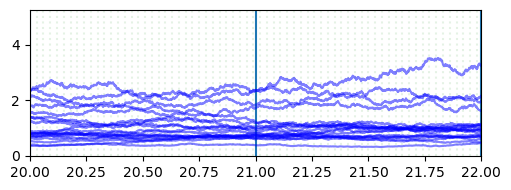

In [42]:
fig = plt.figure(figsize=(5,2))
off_set = 20
n_steps = int(simulation_parameters['tau']  /simulation_parameters['dt'])

for i in range(0, weight_list.shape[0] + 1, n_steps + 1):
    plt.axvline(x=i*simulation_parameters['tau'] + off_set, color='g', linestyle='dotted', alpha = 0.1)

#plot a vertical line every epoch
for i in range(0, 100 , 1):
    plt.axvline(x=i)

times = np.arange(0, weight_list.shape[0]) * simulation_parameters['dt']
plt.plot(times + off_set, weight_list[:, :20], alpha=0.5, c = 'b')
plt.tight_layout()
# plt.xlim(off_set, off_set+weight_list.shape[0]*simulation_parameters['dt'])
plt.xlim(20, 22)
plt.savefig("weight_evolution_zoom.png", dpi=300, bbox_inches='tight')
plt.show()


In [28]:
weight_list.shape


(3600, 8192)

In [21]:
7600/2

3800.0

In [23]:
3800/5

760.0

In [33]:
acc_list

[Array(0.73499995, dtype=float32),
 Array(0.68, dtype=float32),
 Array(0.695, dtype=float32)]